In [1]:
import sys
sys.path.append('../../')
from experiments.risk_scores_data import generate_data, get_nodes_feature, get_age_feature, get_bmi_feature
from experiments.utils import create_df_from_cached_results, load_share_from_checkpoint
from sklearn.metrics import r2_score
from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN
import matplotlib.pyplot as plt
import time
import torch
import pandas as pd
import numpy as np
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
# Read the timestamp from the file
with open('../results/Figure_5_timestamp.txt','r') as f:
    timestamp = f.read()
# Read dataframe
res_df = pd.read_csv(f'../results/Figure_5_results.csv', index_col=0)

In [3]:
res_df

,id,equation,raw_fitness,r2,r2_val,r2_train,n_shapes,n_variables
0,0,"add(X0, X1)",56.171210,-0.196146,-0.470612,-0.254017,0,2
1,1,"add(X0, shape(X2))",8.016266,0.829296,0.708522,0.819090,1,2
2,2,"div(div(shape(X1), shape(X0)), shape(X2))",43.026199,0.083773,-0.042899,0.027062,3,3
3,3,"shape(add(add(X0, shape(X1)), shape(X2)))",6.029292,0.871608,0.708854,0.884999,3,3
4,4,"div(shape(mul(shape(X1), shape(X2))), shape(X0))",2.317979,0.950639,0.911877,0.959921,4,3
...,...,...,...,...,...,...,...,...
483,483,"add(X2, shape(add(X1, X0)))",53.213726,-0.133167,-0.556808,-0.205556,1,3
484,484,"div(shape(X2), add(X0, X1))",9.620143,0.795142,0.148714,0.613118,1,3
485,485,"add(shape(X2), add(X1, X0))",3.072365,0.934575,0.538496,0.876133,1,3
486,486,"add(mul(X0, shape(X1)), X2)",59.241882,-0.261535,-0.358356,-0.264831,1,3


In [4]:
res_df[res_df['n_shapes'] == 0].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                   395
equation              X0
raw_fitness    43.723259
r2              0.068929
r2_val           -0.1152
r2_train       -0.005554
n_shapes               0
n_variables            1
Name: 395, dtype: object

In [5]:
res_df[res_df['n_shapes'] == 1].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                     487
equation       mul(shape(X2), mul(X1, X0))
raw_fitness                       0.003032
r2                                0.999935
r2_val                            0.999899
r2_train                          0.999948
n_shapes                                 1
n_variables                              3
Name: 487, dtype: object

In [6]:
res_df[res_df['n_shapes'] == 2].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                            350
equation       mul(mul(shape(X2), shape(X0)), X1)
raw_fitness                              0.007136
r2                                       0.999848
r2_val                                   0.999752
r2_train                                 0.999895
n_shapes                                        2
n_variables                                     3
Name: 350, dtype: object

In [7]:
res_df[res_df['n_shapes'] == 3].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                                    94
equation       div(mul(shape(X2), shape(X1)), shape(X0))
raw_fitness                                      0.00828
r2                                              0.999824
r2_val                                          0.999612
r2_train                                        0.999838
n_shapes                                               3
n_variables                                            3
Name: 94, dtype: object

In [8]:
res_df[res_df['n_shapes'] == 4].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                                          215
equation       shape(mul(mul(shape(X2), shape(X0)), shape(X1)))
raw_fitness                                            0.009031
r2                                                     0.999808
r2_val                                                 0.999403
r2_train                                               0.999842
n_shapes                                                      4
n_variables                                                   3
Name: 215, dtype: object

In [9]:
def _protected_inverse(x1):
    """Closure of inverse for zero arguments."""
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)
    
def evaluate_shape(shape,t,invert=False, scale=1.0):
    shape.to(torch.device('cpu'))
    t = torch.from_numpy(t).float()
    shape.eval()
    with torch.no_grad():
        if invert:
            return scale * _protected_inverse(shape(t).numpy().flatten())
        else:
            return scale * shape(t).numpy().flatten()

In [10]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
linewidth = 3.0
alpha = 0.5
markersize = 5.0
label_fontsize = 18

In [11]:
def extract_slope_intercept(shape,x_low, x_high, invert=False, scale=1.0):
    x = np.linspace(x_low,x_high,100)
    ys = evaluate_shape(shape,x,invert=invert,scale=scale)
    slope, intercept = np.polyfit(x,ys,1)
    # slope = (ys[1]-ys[0])/(args[1]-args[0])
    # intercept = ys[0] - slope * args[0]
    return slope, intercept

In [12]:
def plot_1(ax):
    sorted_filtered = res_df[res_df['n_shapes'] == 1].sort_values(by='r2_train',ascending=False)
    eq = sorted_filtered.iloc[0,1]
    id = sorted_filtered.iloc[0,0]
    esr_best_1 = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='../results/checkpoints', task='regression',n_features=3, equation_id=id)

    s3 = esr_best_1._program.model.shape_functions[0]

    t = np.linspace(0,5,1000)
    ax.plot(t,np.sin(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label=r'$\sin$')
    ax.plot(t,evaluate_shape(s3,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"$s_3$")
    ax.set_xlabel(r'$\theta$', fontsize=label_fontsize)
    ax.set_ylabel("Value", fontsize=label_fontsize)
    # plt.xscale('log')
    ax.legend(fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=15)


In [13]:
def plot_2(ax):
    sorted_filtered = res_df[res_df['n_shapes'] == 3].sort_values(by='r2_train',ascending=False)
    eq = sorted_filtered.iloc[0,1]
    id = sorted_filtered.iloc[0,0]
    esr_best_3 = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='../results/checkpoints', task='regression',n_features=3, equation_id=id)
    print(esr_best_3)
    s1 = esr_best_3._program.model.shape_functions[2]
    s2 = esr_best_3._program.model.shape_functions[1]
    s3 = esr_best_3._program.model.shape_functions[0]



    t = np.linspace(0,5,1000)

    a_org, b_org = extract_slope_intercept(s2,2,5)


    max_s3 = np.max(evaluate_shape(s3,t))
    min_s3 = np.min(evaluate_shape(s3,t))

    amplitude_s3 = (max_s3 - min_s3) / 2


    # plt.plot(t,np.sin(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label=r'$\sin$')
    ax.plot(t,evaluate_shape(s1,t,invert=True,scale=amplitude_s3*a_org),c=colors[2],linewidth=linewidth, alpha=alpha, label=r"$s_1$")
    ax.plot(t,evaluate_shape(s2,t, scale=1/a_org),c=colors[3],linewidth=linewidth, alpha=alpha, label=r"$s_2$")
    ax.plot(t,evaluate_shape(s3,t, scale=1/amplitude_s3),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"$s_3$")
    ax.set_xlabel(r'$r$ / $F$ / $\theta$', fontsize=label_fontsize)
    ax.set_ylabel("Value", fontsize=label_fontsize)
    # plt.xscale('log')
    ax.legend(fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=15)

    a1, b1 = extract_slope_intercept(s1,2,5,invert=True,scale=amplitude_s3*a_org)
    a2, b2 = extract_slope_intercept(s2,2,5,scale=1/a_org)
    print(a1,b1,a2,b2)

mul(shape(X2), mul(X1, X0))
div(mul(shape(X2), shape(X1)), shape(X0))
div(mul(shape(X2), shape(X1)), shape(X0))
-0.983170118379121 -0.07251801235841135 1.0000000402714948 0.016562161162349653


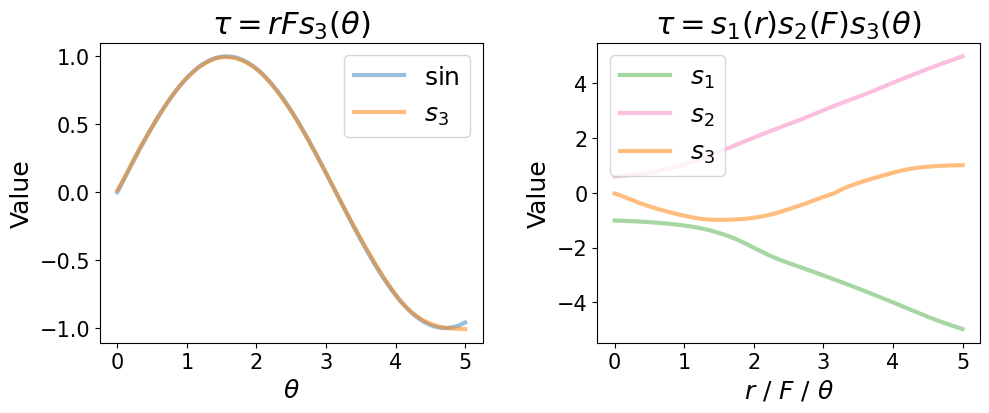

In [14]:
title_fontsize = 22
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
plot_1(ax1)
plot_2(ax2)
ax1.title.set_text(r"$\tau = r F s_3(\theta)$")
ax2.title.set_text(r"$\tau = s_1(r) s_2(F) s_3(\theta) $")
ax1.title.set_fontsize(title_fontsize)
ax2.title.set_fontsize(title_fontsize)
plt.subplots_adjust(left=0.10, bottom=0.15, right=0.98, top=0.9, wspace=0.3, hspace=None)

plt.savefig('figures/Figure_5.pdf')